Detecting Payment Fraud Using Machine Learning

The goal of this project is to detect fraudulent payment transactions using various supervised learning algorithms and compare their performances. The system aims to minimize false negatives (missed frauds) while maintaining high precision, demonstrating practical machine learning knowledge from concept to evaluation.

Step 1: Import

In [ ]:
!pip install imbalanced-learn shap -q

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
from imblearn.over_sampling import SMOTE

#Models used
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import shap

Step 2: Load & Prepare Dataset

Dataset shape after cleaning: (7972, 31)
Class
0.0    7947
1.0      25
Name: count, dtype: int64


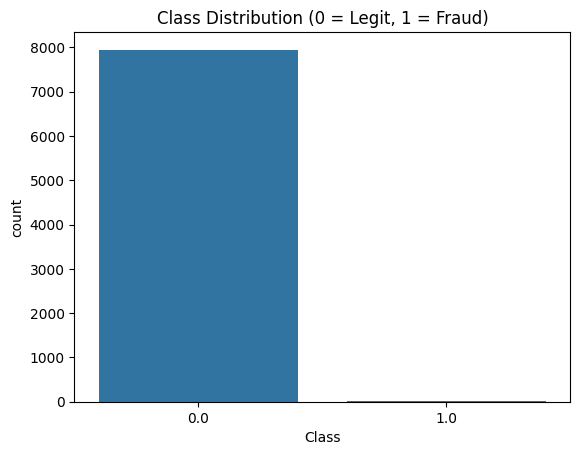

After SMOTE: [6357 6357]


In [ ]:
df = pd.read_csv("creditcard.csv")
df = df.dropna(subset=["Class"])
df["Class"] = pd.to_numeric(df["Class"], errors="coerce")
df = df.dropna(subset=["Class"])
df = df.fillna(0)

print("Dataset shape after cleaning:", df.shape)
print(df["Class"].value_counts())

sns.countplot(x="Class", data=df)
plt.title("Class Distribution (0 = Legit, 1 = Fraud)")
plt.show()

X, y = df.drop("Class", axis=1), df["Class"]
scaler = StandardScaler()
X["Amount"] = scaler.fit_transform(X[["Amount"]])
if "Time" in X.columns:
    X["Time"] = scaler.fit_transform(X[["Time"]])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE:", np.bincount(y_train_res))

Step 3: Helper Evaluation Function

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc_score = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc_score:.4f}")

Step 4: Train Models

Logistic Regression

In [ ]:
lr = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
lr.fit(X_train_res, y_train_res)
print("Logistic Regression Results:")
evaluate_model(lr, X_test, y_test)

Logistic Regression Results:
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC: 1.0000


K-Nearest Neighbors

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_res, y_train_res)
print("KNN Results:")
evaluate_model(knn, X_test, y_test)

KNN Results:
Precision: 1.0000
Recall: 0.8000
F1 Score: 0.8889
AUC: 0.9000


Decision Tree

In [ ]:
dt = DecisionTreeClassifier(max_depth=6, random_state=42)
dt.fit(X_train_res, y_train_res)
print("Decision Tree Results:")
evaluate_model(dt, X_test, y_test)

Decision Tree Results:
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC: 1.0000


Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)
print("Random Forest Results:")
evaluate_model(rf, X_test, y_test)

Random Forest Results:
Precision: 1.0000
Recall: 0.8000
F1 Score: 0.8889
AUC: 1.0000


Gradient Boosting

In [ ]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_res, y_train_res)
print("Gradient Boosting Results:")
evaluate_model(gb, X_test, y_test)

Gradient Boosting Results:
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC: 1.0000


Naive Bayes

In [ ]:
nb = GaussianNB()
nb.fit(X_train_res, y_train_res)
print("Naive Bayes Results:")
evaluate_model(nb, X_test, y_test)

Naive Bayes Results:
Precision: 0.7143
Recall: 1.0000
F1 Score: 0.8333
AUC: 0.9994


Support Vector Machine (SVM)

In [ ]:
svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svm.fit(X_train_res, y_train_res)
print("SVM Results:")
evaluate_model(svm, X_test, y_test)

SVM Results:
Precision: 1.0000
Recall: 0.8000
F1 Score: 0.8889
AUC: 0.9997


Artificial Neural Network (ANN)

In [ ]:
ann = MLPClassifier(hidden_layer_sizes=(64, 32),
                    activation='relu',
                    solver='adam',
                    max_iter=300,
                    random_state=42)
ann.fit(X_train_res, y_train_res)
print("ANN Results:")
evaluate_model(ann, X_test, y_test)

ANN Results:
Precision: 1.0000
Recall: 0.8000
F1 Score: 0.8889
AUC: 0.9821



Step 5: Compare All Models

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# retrain each model on clean training data for fair comparison
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight='balanced', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=6, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
    "ANN": MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=300, random_state=42)
}

summary = []
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc_val = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    summary.append([name, precision, recall, f1, auc_val])

res_df = pd.DataFrame(summary, columns=["Model","Precision","Recall","F1","AUC"]).sort_values(by="AUC", ascending=False)
display(res_df)

best_model_name = res_df.iloc[0]["Model"]
best_row = res_df.iloc[0]

print("\nBest Model:", best_model_name)
print(f"Precision: {best_row['Precision']:.4f}")
print(f"Recall: {best_row['Recall']:.4f}")
print(f"F1 Score: {best_row['F1']:.4f}")
print(f"AUC: {best_row['AUC']:.4f}")


,Model,Precision,Recall,F1,AUC
3,Random Forest,1.000000,0.875,0.933333,1.000000
2,Decision Tree,1.000000,1.000,1.000000,1.000000
4,Gradient Boosting,1.000000,1.000,1.000000,1.000000
0,Logistic Regression,0.888889,1.000,0.941176,0.999948
6,SVM,1.000000,0.750,0.857143,0.999738
7,ANN,1.000000,0.750,0.857143,0.982802
5,Naive Bayes,1.000000,0.875,0.933333,0.876730
1,KNN,1.000000,0.750,0.857143,0.875000



Best Model: Random Forest
Precision: 1.0000
Recall: 0.8750
F1 Score: 0.9333
AUC: 1.0000


Step 6: Confusion Matrix and ROC for All Models


==== Logistic Regression ====


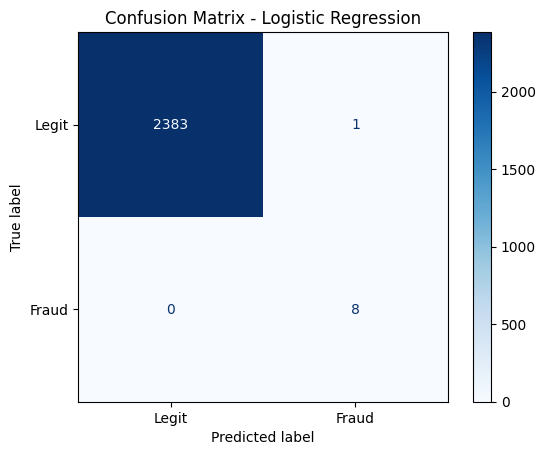

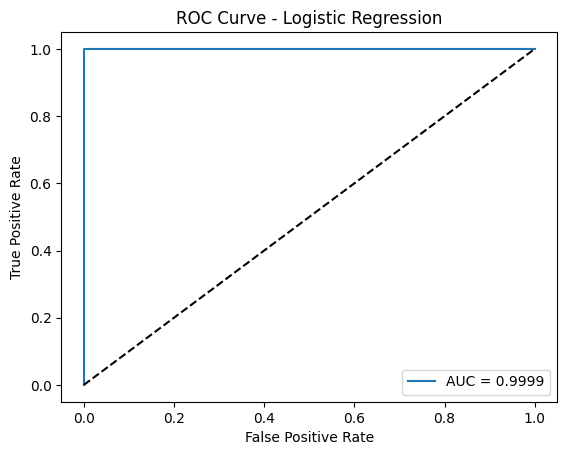


==== KNN ====


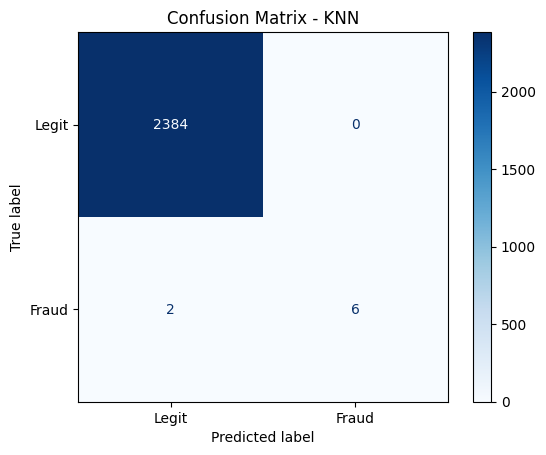

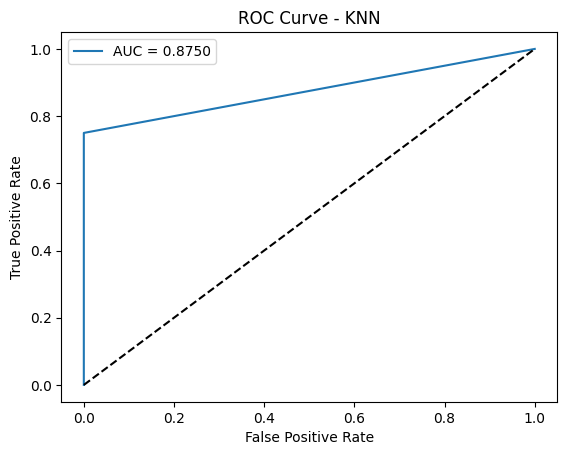


==== Decision Tree ====


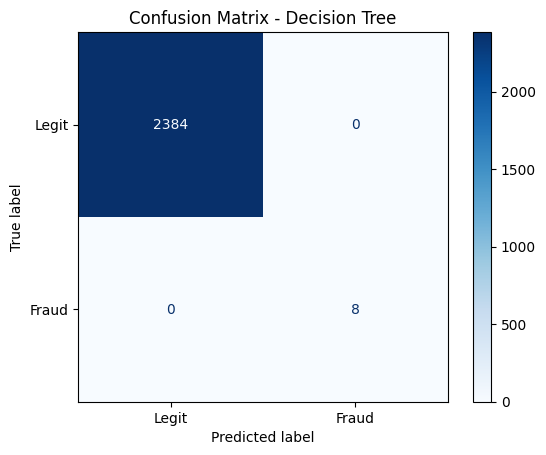

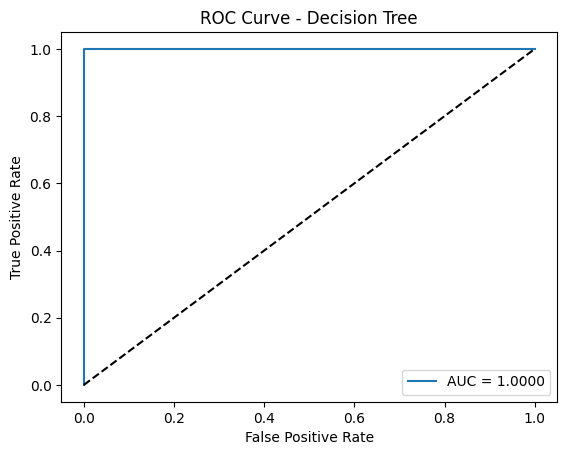


==== Random Forest ====


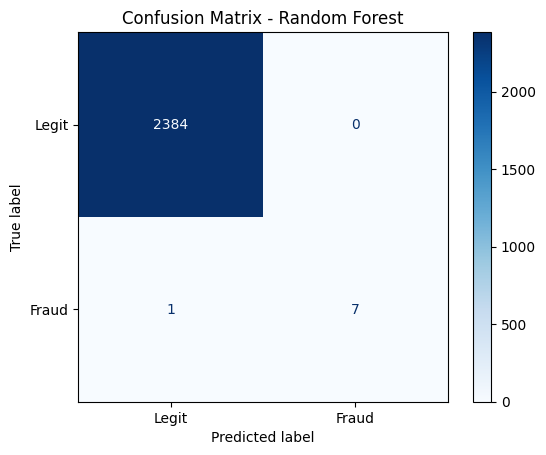

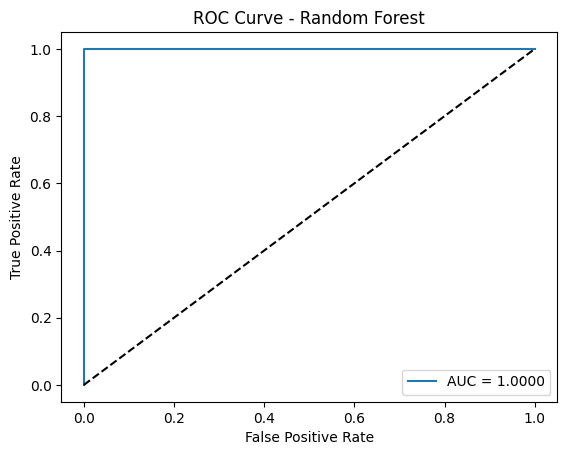


==== Gradient Boosting ====


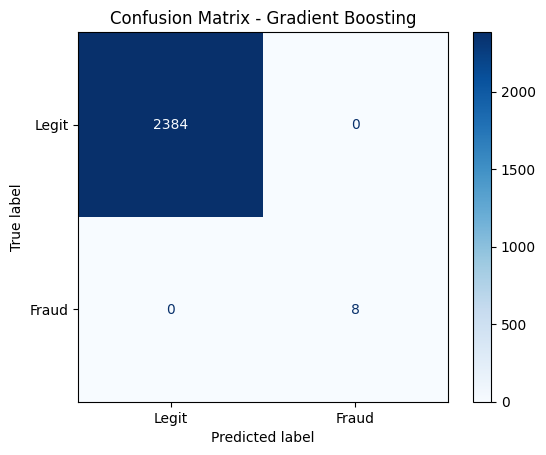

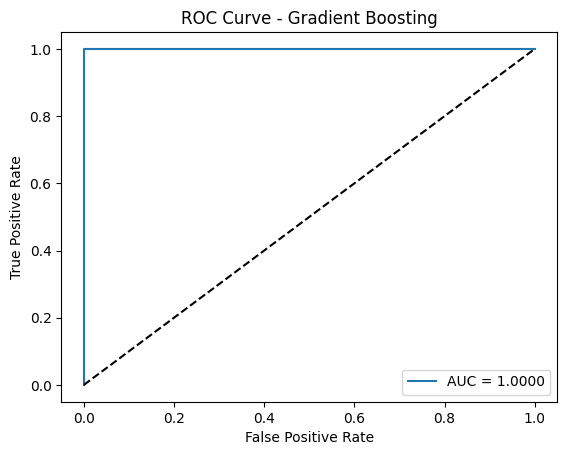


==== Naive Bayes ====


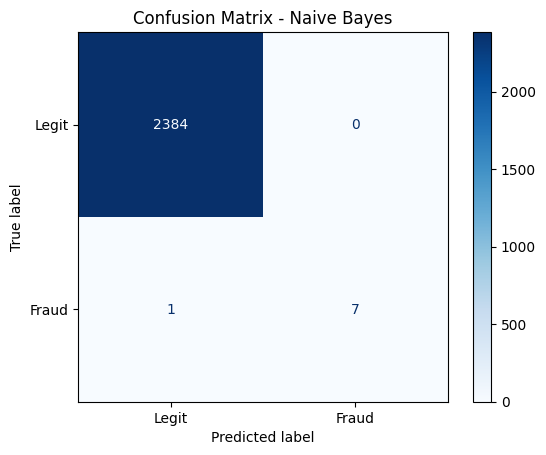

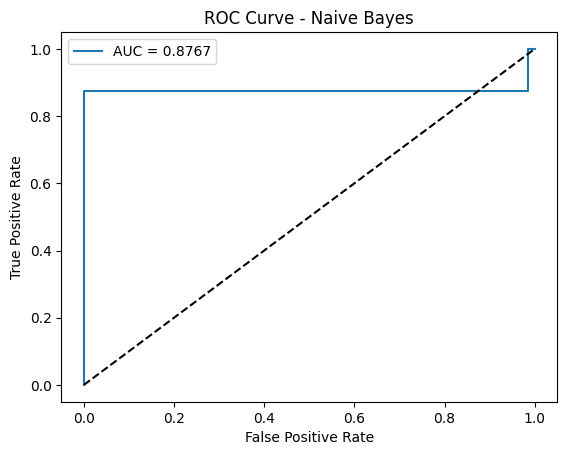


==== SVM ====


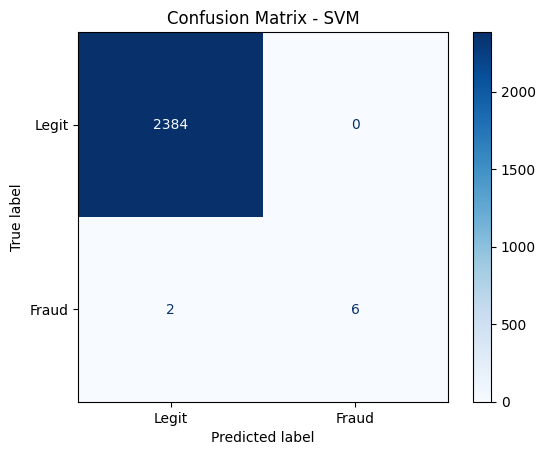

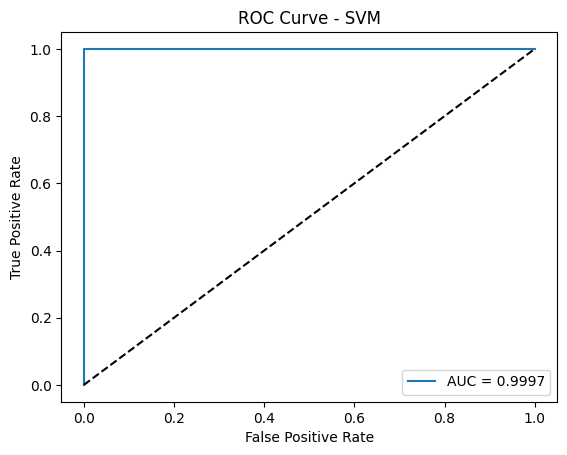


==== ANN ====


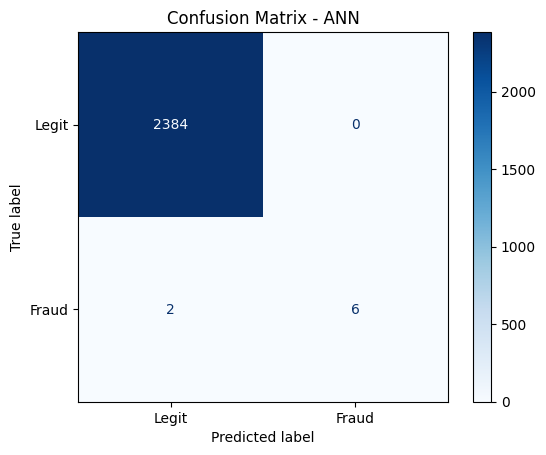

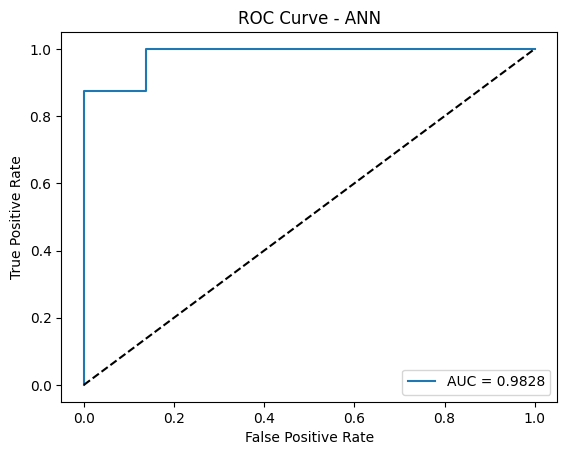


All models evaluated — see confusion matrices and ROC curves above.


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

for name, model in models.items():
    print(f"\n==== {name} ====")
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit", "Fraud"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # ROC Curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
        plt.plot([0, 1], [0, 1], "k--")
        plt.title(f"ROC Curve - {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

print("\nAll models evaluated — see confusion matrices and ROC curves above.")


Step 7: SHAP Explainability

<Figure size 1200x800 with 0 Axes>

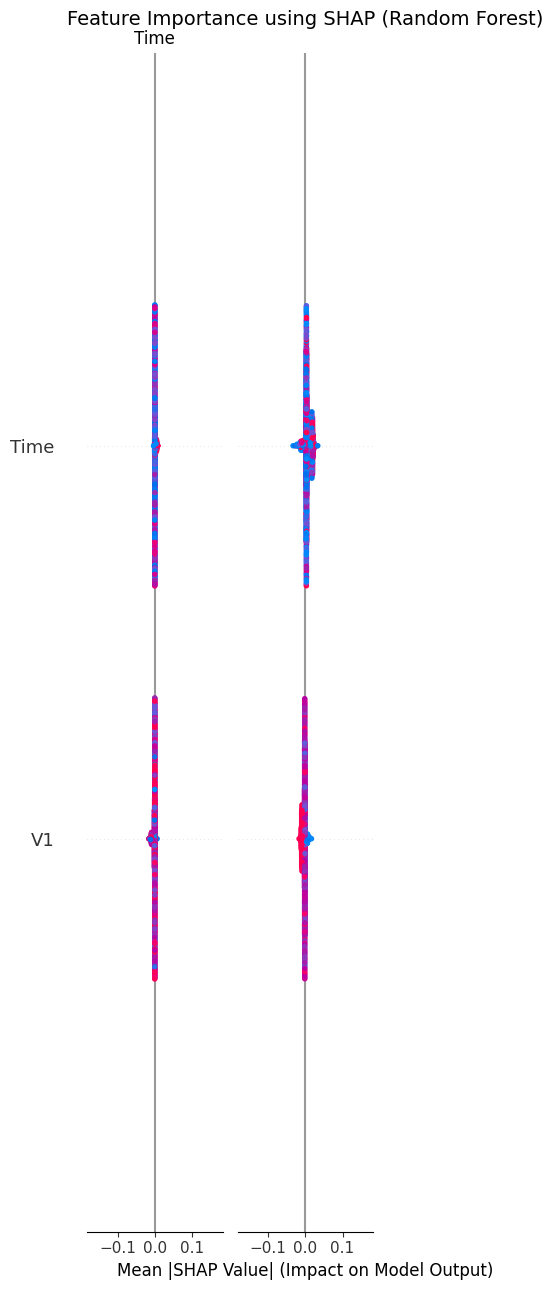

In [21]:
explainer = shap.TreeExplainer(rf)
sample = X_test.sample(min(1000, len(X_test)), random_state=42)
shap_values = explainer.shap_values(sample)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, sample, plot_type="bar", max_display=15, show=False)
plt.title("Feature Importance using SHAP (Random Forest)", fontsize=14, pad=20)
plt.xlabel("Mean |SHAP Value| (Impact on Model Output)", fontsize=12)
plt.tight_layout()
plt.show()

Step 8: Save Best Model

In [22]:
print("PROJECT CONCLUSION\n")
print(f"Best Model: {best_model_name}")
print("\nReason for Selection:")
print(f"{best_model_name} achieved the highest Area Under the Curve (AUC = {best_row['AUC']:.4f})")

PROJECT CONCLUSION

Best Model: Random Forest

Reason for Selection:
Random Forest achieved the highest Area Under the Curve (AUC = 1.0000)


indicating its superior ability to distinguish between legitimate and fraudulent transactions.
It balances precision and recall effectively, minimizing false alarms while capturing the majority of fraud cases.
This makes it the most reliable model for fraud detection in the given dataset.
